# Spaceship Titanic XGBoost Classifier



## Kaggle Competition
https://www.kaggle.com/competitions/spaceship-titanic/overview

## Data
* training set: `train.csv` contains ~8700 passengers
* test set: `test.csv` contains ~4300 passengers

## 1. Problem

Our goal is to accurately classify whether or not a passenger aboard the spaceship titanic was successfully transported.

## 2. Data

Our data are structured tabular data which have been presplit into training and testing sets. I will combine into a `combined` dataset for data cleaning and EDA.

In [377]:
# import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [378]:
# inspect  data
path = os.getcwd()
train = pd.read_csv(path+"//train.csv")
test = pd.read_csv(path+"//test.csv")
combined = pd.concat([train,test],sort=False, ignore_index=True)
test_Ids = test['PassengerId']
print(combined.shape)
combined.head()

(12970, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 3. Data exploration

### Viewing distributions of continuous variables for those transported and not transported.

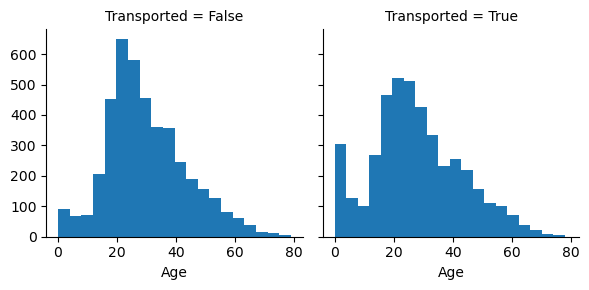

In [379]:
fg = sns.FacetGrid(combined,col='Transported')
fg.map(plt.hist,'Age',bins=20)
plt.show()

A couple things:
1. We have a similar number of +ve and -ve target labels (classes are balanced) 
2. Age is skewed to younger passengers and babies/toddlers were more likely to be transported.

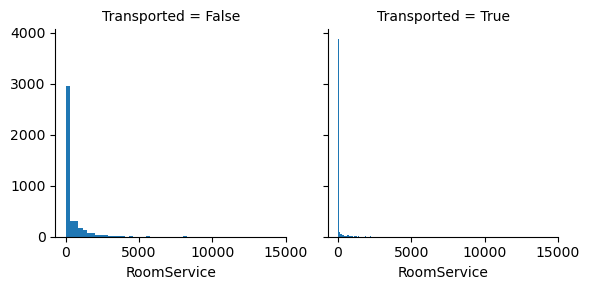

In [380]:
fg = sns.FacetGrid(combined,col='Transported')
fg.map(plt.hist,'RoomService',bins=50)
plt.show()

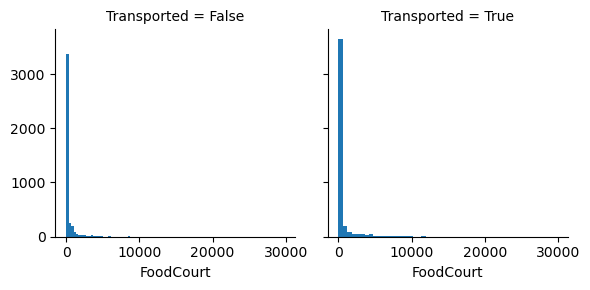

In [381]:
fg = sns.FacetGrid(combined,col='Transported')
fg.map(plt.hist,'FoodCourt',bins=50)
plt.show()

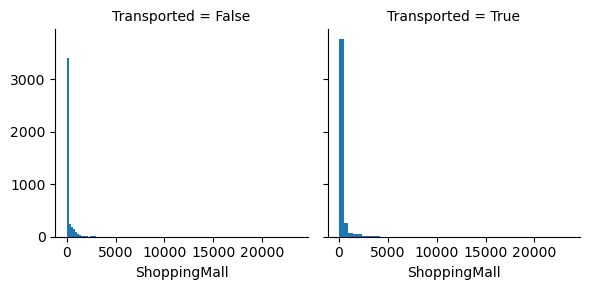

In [382]:
fg = sns.FacetGrid(combined,col='Transported')
fg.map(plt.hist,'ShoppingMall',bins=50)
plt.show()

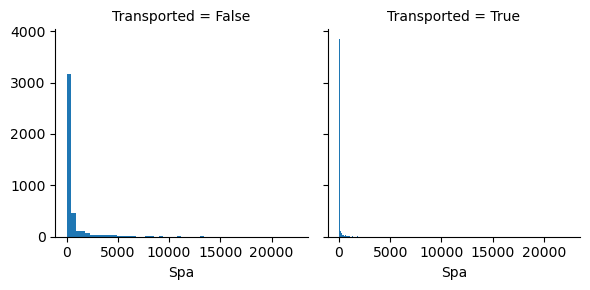

In [383]:
fg = sns.FacetGrid(combined,col='Transported')
fg.map(plt.hist,'Spa',bins=50)
plt.show()

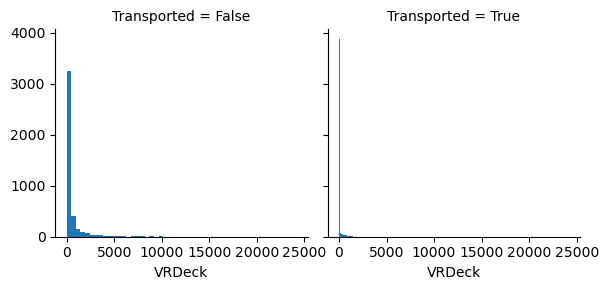

In [384]:
fg = sns.FacetGrid(combined,col='Transported')
fg.map(plt.hist,'VRDeck',bins=50)
plt.show()

Discretionary spending is highly skewed, with the majority of passengers spending low (or no) amounts on board.

## 4. Data cleaning

### Drop unhelpful/uncorrelated features

In [385]:
# starting by dropping passenger name
combined.drop(['Name'],axis=1,inplace=True)
combined.shape

(12970, 13)

In [386]:
# null values
print('# passengers containing at least 1 missing value: ', 
      sum(combined.apply(lambda x: sum(x.isnull().values), axis = 1)>0))
combined.isnull().sum()

# passengers containing at least 1 missing value:  6206


PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Transported     4277
dtype: int64

### Data imputation.

As a large amount of data would be dropped if null cases were removed, data imputation is likely a better option.

Missing values for continuous features imputed by median.

Missing values for categorical features imputed by most_frequent.

In [387]:
# continuous features
combined['Age'] = combined['Age'].fillna(combined['Age'].median())
combined['RoomService'] = combined['RoomService'].fillna(combined['RoomService'].median())
combined['FoodCourt'] = combined['FoodCourt'].fillna(combined['FoodCourt'].median())
combined['ShoppingMall'] = combined['ShoppingMall'].fillna(combined['ShoppingMall'].median())
combined['Spa'] = combined['Spa'].fillna(combined['Spa'].median())
combined['VRDeck'] = combined['VRDeck'].fillna(combined['VRDeck'].median())

# categorical features
combined['HomePlanet'] = combined['HomePlanet'].fillna(combined['HomePlanet'].mode().iloc[0])
combined['CryoSleep'] = combined['CryoSleep'].fillna(combined['CryoSleep'].mode().iloc[0])
combined['Destination'] = combined['Destination'].fillna(combined['Destination'].mode().iloc[0])
combined['VIP'] = combined['VIP'].fillna(combined['VIP'].mode().iloc[0])
combined.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            299
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
dtype: int64

## 5. Feature engineering

A few features that may help:
1. Age groupings
2. Luxury spending habits
3. Travel journey
4. Cabin location
5. Travel group info

### Age groupings

In [388]:
# band into baby, child, adult, elderly
combined['AgeBand'] = pd.cut(combined.Age,
                             bins=[-1,2,17,65,99],
                             labels=['Baby','Child','Adult','Elderly'])
combined.drop(['Age'],axis=1,inplace=True)
age_df = combined['AgeBand']

# one-hot-encode labels
dum_df = pd.get_dummies(age_df, columns = ['AgeBand'], prefix = 'AgeBand_is') # generate binary values
combined = combined.join(dum_df)
combined.drop(['AgeBand'],axis=1,inplace=True)
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeBand_is_Baby,AgeBand_is_Child,AgeBand_is_Adult,AgeBand_is_Elderly
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,0,0,1,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,0,0,1,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0,1,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,0,0,1,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,0,1,0,0


### Luxury spending habits

A couple of interesting features we can investigate are
* `total_spent` - total spending across all luxury services
* `n_amenities` - number of amenities a passenger spent money on

In [389]:
spending = combined[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
combined['total_spent'] = spending.sum(axis=1)
combined['n_amenities'] = spending[spending > 0].notnull().sum(axis=1)
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeBand_is_Baby,AgeBand_is_Child,AgeBand_is_Adult,AgeBand_is_Elderly,total_spent,n_amenities
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,0,0,1,0,0.0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,0,0,1,0,736.0,5
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0,1,0,10383.0,4
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,0,0,1,0,5176.0,4
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,0,1,0,0,1091.0,5


### Travel journey

An interesting bit of info is to capture the interaction between `HomePlanet` and `Destination` as the `Route` (HomePlanet --> Destination)

In [390]:
# form route, i.e. the journey
combined['Route'] = combined['HomePlanet']+'_to_'+combined['Destination']
combined.drop(['HomePlanet','Destination'],axis=1,inplace=True)
route_df = combined['Route']

# one-hot-encode
dum_df = pd.get_dummies(route_df, columns = ['Route'], prefix = 'Route_is') # generate binary values
combined = combined.join(dum_df)
combined.drop(['Route'],axis=1,inplace=True)
combined.head()

,PassengerId,CryoSleep,Cabin,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,n_amenities,Route_is_Earth_to_55 Cancri e,Route_is_Earth_to_PSO J318.5-22,Route_is_Earth_to_TRAPPIST-1e,Route_is_Europa_to_55 Cancri e,Route_is_Europa_to_PSO J318.5-22,Route_is_Europa_to_TRAPPIST-1e,Route_is_Mars_to_55 Cancri e,Route_is_Mars_to_PSO J318.5-22,Route_is_Mars_to_TRAPPIST-1e
0,0001_01,False,B/0/P,False,0.0,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,1,0,0,0
1,0002_01,False,F/0/S,False,109.0,9.0,25.0,549.0,44.0,True,...,5,0,0,1,0,0,0,0,0,0
2,0003_01,False,A/0/S,True,43.0,3576.0,0.0,6715.0,49.0,False,...,4,0,0,0,0,0,1,0,0,0
3,0003_02,False,A/0/S,False,0.0,1283.0,371.0,3329.0,193.0,False,...,4,0,0,0,0,0,1,0,0,0
4,0004_01,False,F/1/S,False,303.0,70.0,151.0,565.0,2.0,True,...,5,0,0,1,0,0,0,0,0,0


### Cabin location

This needs to be divided into the deck, number, and side of the ship. Number is dropped. 

In [391]:
combined[["Cabin_deck","Cabin_no.","Cabin_side"]]=combined["Cabin"].str.split("/",expand=True)
# drop original label and cabin number
combined.drop("Cabin",axis=1,inplace=True)
combined.drop("Cabin_no.",axis=1,inplace=True)
# impute missing values with most frequent label
combined['Cabin_deck'].fillna(combined['Cabin_deck'].mode()[0],inplace=True)
combined['Cabin_side'].fillna(combined['Cabin_side'].mode()[0],inplace=True)

# one-hot-encode
dum_df = pd.get_dummies(combined['Cabin_deck'], columns = ['Cabin_deck'], prefix = 'Cabin_deck_is') # generate binary values
combined = combined.join(dum_df)
combined.drop(['Cabin_deck'],axis=1,inplace=True)

dum_df = pd.get_dummies(combined['Cabin_side'], columns = ['Cabin_side'], prefix = 'Cabin_side_is')
combined = combined.join(dum_df)
combined.drop(['Cabin_side'], axis=1, inplace=True)

combined.head()

,PassengerId,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeBand_is_Baby,...,Cabin_deck_is_A,Cabin_deck_is_B,Cabin_deck_is_C,Cabin_deck_is_D,Cabin_deck_is_E,Cabin_deck_is_F,Cabin_deck_is_G,Cabin_deck_is_T,Cabin_side_is_P,Cabin_side_is_S
0,0001_01,False,False,0.0,0.0,0.0,0.0,0.0,False,0,...,0,1,0,0,0,0,0,0,1,0
1,0002_01,False,False,109.0,9.0,25.0,549.0,44.0,True,0,...,0,0,0,0,0,1,0,0,0,1
2,0003_01,False,True,43.0,3576.0,0.0,6715.0,49.0,False,0,...,1,0,0,0,0,0,0,0,0,1
3,0003_02,False,False,0.0,1283.0,371.0,3329.0,193.0,False,0,...,1,0,0,0,0,0,0,0,0,1
4,0004_01,False,False,303.0,70.0,151.0,565.0,2.0,True,0,...,0,0,0,0,0,1,0,0,0,1


### Travel group info

Find whether the passenger traveled alone or with a group.

In [392]:
combined[['Group','Member']]=combined['PassengerId'].str.split('_',expand=True) # split PassengerId to Group, Member
x=combined.groupby('Group')['Member'].count().sort_values(ascending=False) # Count members at each group
combined['is_alone']=combined['Group'].apply(lambda y: y in set(x[x>1].index)) # create new column for groups have more than 1 member
combined['is_alone']=combined['is_alone'].map({True:1,False:0}).astype('int8')
combined.drop(['PassengerId','Group','Member'],axis=1,inplace=True)
combined.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeBand_is_Baby,AgeBand_is_Child,...,Cabin_deck_is_B,Cabin_deck_is_C,Cabin_deck_is_D,Cabin_deck_is_E,Cabin_deck_is_F,Cabin_deck_is_G,Cabin_deck_is_T,Cabin_side_is_P,Cabin_side_is_S,is_alone
0,False,False,0.0,0.0,0.0,0.0,0.0,False,0,0,...,1,0,0,0,0,0,0,1,0,0
1,False,False,109.0,9.0,25.0,549.0,44.0,True,0,0,...,0,0,0,0,1,0,0,0,1,0
2,False,True,43.0,3576.0,0.0,6715.0,49.0,False,0,0,...,0,0,0,0,0,0,0,0,1,1
3,False,False,0.0,1283.0,371.0,3329.0,193.0,False,0,0,...,0,0,0,0,0,0,0,0,1,1
4,False,False,303.0,70.0,151.0,565.0,2.0,True,0,1,...,0,0,0,0,1,0,0,0,1,0


### One-hot-encode remaining categorical features

Cryosleep, VIP

In [393]:
combined['CryoSleep']=combined['CryoSleep'].map({True:1,False:0}).astype('int8')
combined['VIP']=combined['VIP'].map({True:1,False:0}).astype('int8')

## 5. Feature --> Target Model

Using extreme gradient boosting `XGBoost` to solve a binary classification problem.

The selected metric is accuracy in line with the Kaggle competition.

In [394]:
train=combined.iloc[:train.shape[0],:]
train['Transported']=train['Transported'].map({True:1,False:0}).astype('int8')
test=combined.iloc[train.shape[0]:,:]
test.drop(['Transported'],axis=1, inplace=True)

y_train = train.pop('Transported')
# y_test is hidden for the competition

X_train = train
X_test = test

C:\Users\chris\AppData\Local\Temp\ipykernel_19492\2603324571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Transported']=train['Transported'].map({True:1,False:0}).astype('int8')
C:\Users\chris\AppData\Local\Temp\ipykernel_19492\2603324571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['Transported'],axis=1, inplace=True)


In [395]:
X_train.shape, y_train.shape, X_test.shape

((8693, 33), (8693,), (4277, 33))

In [396]:
# a simple function returning y_hat and accuracy on the training set
def model_prediction(model,X_train,y_train,X_test):
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    accuracy = round(model.score(X_train,y_train)*100,2)
    return y_hat, accuracy

In [397]:
# parameter grid for random search cross validation
random_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
  "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
  "min_child_weight" : [ 1, 3, 5, 7 ],
  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [401]:
# train the binary classifier and make predictions on the test data
clf = xgb.XGBClassifier()
random_best = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                                n_iter=100,cv=5,verbose=1,random_state=1,n_jobs=-1)

y_hat, train_accuracy = model_prediction(random_best, X_train, y_train, X_test)
y_hat = y_hat.astype('bool')

print(f'Accuracy was {train_accuracy}% on the training set')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy was 85.03% on the training set


## 6. Save predictions for submission

In [402]:
output = pd.DataFrame({'PassengerId': test_Ids, 'Transported': y_hat})
output.to_csv('submission.csv', index=False)